# Constructing endogenous value function $R(\cdot, \rho, i, z)$ via lotteries

Source codes prepared by [T. Kam, H.S. Lee, S. Ng](https://i.pinimg.com/736x/60/00/c4/6000c446ade9ff211f45c51b96bc3109.jpg)

In [10]:
import bcw_bj_Lemma_1 as bcw_bj
import numpy as np
import scipy as sp
from textwrap import dedent
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sys
import time
import collections as collections
from cycler import cycler

from scipy.spatial import ConvexHull
import setops as setops # Custom module by TK, from CSM

import sympy as sym
from IPython.display import display, Math

In [11]:
# Instantiate class as MODEL object, at current calibrated params
self = bcw_bj.baseline_mod(σ_DM=0.28, c=1.0)

# Set (partial) equilibrium i to calibrated SME solution
i = 0.021692264956258474

## New functions added

In [12]:
def z_cutoffs(self, i):
    """Define the four cutoff levels for z as in Lemmata 1-3:
    0 < z_tilde_i < zhat < z_prime < ∞."""

    z_hat = (self.c/(1-self.σ_DM))**((self.σ_DM-1)/self.σ_DM)
    z_prime = z_hat*(1/(1-self.σ_DM))**(-(self.σ_DM-1)/self.σ_DM)
    z_tilde = z_hat*(1+i)**(-1/self.σ_DM)
    # z_breve = (1-self.c) + z_hat*self.σ_DM
    # z_breve =((1+self.σ_DM*z_tilde)/self.c)**(1-self.σ_DM)
    
    # Sanity check!
    # zcut = np.diff([z_tilde, z_hat])
    if z_tilde <= z_hat:
        print("🥳 Congrats: Your cutoffs are in order!")
        z_cutoffs_str = '\\tilde{z}_{i} < \\hat{z} < z^{\\prime}'
        display(
            Math(z_cutoffs_str)
            )
        z_cutoffs = [z_tilde, z_hat, z_prime] 
        print(['%.3f' % x for x in z_cutoffs])
    else:
        print("💩 You have a problem with your cutoff ordering!")
            
    return z_tilde, z_hat, z_prime 

In [13]:
def R(self, p_grid, Rex, DropFakes=True):
    """Find convex hull of graph(Rex) to get R - See Appendix B.3
    Taken from https://github.com/phantomachine/csm/
    """
    Rex_graph = np.column_stack((p_grid, Rex))
    
    # Step 0:   Find Convex hull of { ρ, Rex(ρ) }
    mpoint = np.array([p_grid.max(), Rex.min()])  # SE corner
    graph = np.vstack((Rex_graph, mpoint))
    chull = ConvexHull(graph)
    extreme_pts = graph[chull.vertices, :]
    
    # Step 1: Intersection between original function Rex and ext. pts.
    v_intersect_graph, ind = setops.intersect(Rex_graph, extreme_pts)[0:2]
    
    # Step 2: First difference the index locations
    idiff = np.diff(ind, n=1, axis=0)
    
    # Step 3: if idiff contains elements > 1 then we know exist one/more line 
    # segment (i.e., more than one set of lotteries played). Location where 
    # straddles more than 1 step
    idz = np.where(idiff > 1)[0]
   
    # Step 4: Given the jumps, we have the end points defining each lottery!
    idz = np.column_stack((idz, idz+1))
    
    # Step 5: Store lottery supports
    lottery_supports = v_intersect_graph[idz, 0]
    lottery_payoffs = v_intersect_graph[idz, 1]
    
    # print(lottery_supports)
    # Step 6: Interpolate to approximate R
    R_fit = self.InterpFun1d(v_intersect_graph[:, 0],
                            v_intersect_graph[:, 1])
    
    # Step 7: Eliminate Fake Lotteries (below-tolerance numerical imprecisions)
    if DropFakes:
        selector = []
        for idx_lot in range(lottery_supports.shape[0]):
            # Lottery prizes for at current lottery segment, idx_lot
            p_lo, p_hi = lottery_supports[idx_lot, :]
            # Conditions: points between current lottery segment
            find_condition = (p_grid > p_lo) & (p_grid < p_hi)
            # Value of Vtilde between current lottery segment
            Rex_p_temp = Rex[find_condition]
            # Value of V between current lottery segment
            R_p_temp = R_fit(p_grid[find_condition])
            # Check: Is R "significantly different" from Rex at lottery segment?
            gap = np.absolute(R_p_temp - Rex_p_temp).max()
            if gap > 1e-8:
                selector.append(idx_lot)  # Keep, if "YES"
        # Update definition of the set of lotteries
        lottery_supports_temp = lottery_supports[selector, :]
        lottery_payoffs_temp = lottery_payoffs[selector, :]
        # if lottery_supports_temp.size == 0:
        #     lottery_supports = lottery_supports[0, :]
        #     lottery_payoffs = lottery_payoffs[0, :]
        # else:
        if lottery_supports_temp.size > 0:
            lottery_supports = lottery_supports_temp
            lottery_payoffs = lottery_payoffs_temp
    # print(lottery_supports)
    # Step 8: Store R as evaluated on finite set p_grid
    R_grid = R_fit(p_grid)
    return R_grid, R_fit, lottery_supports, lottery_payoffs

In [14]:
def plotRfun(self, i, z, ρ_range):

        ρ_hat = self.ρ_hat_func(z)
        ρ_tilde = self.ρ_tilde_func(z, i)
        ρ_m0 = self.c/(1-self.σ_DM)
        # ρ_range = np.linspace(self.c, 1.5, 1000)

        fig, ax = plt.subplots()
        # Graph - profit from credit buyers
        plt.plot(ρ_range, self.G1(ρ_range, i, z),
                label=r"$G_{1}$", color="b", linestyle='dotted')
        # Graph - profit from money constrained
        plt.plot(ρ_range, self.G2(ρ_range, i, z),
                label=r"$G_{2}$", color="orange", linestyle="--")
        # Graph - profit from money unconstrained
        plt.plot(ρ_range, self.G3(ρ_range, i, z),
                label=r"$G_{3}$", color="green", linestyle='dashdot')
        # Ex-post profit (R^{ex})
        Rex = self.R_ex(ρ_range, i, z)
        plt.plot(ρ_range, Rex,
                label=r"$R^{ex}$",
                color="r",
                linewidth=2.5,
                alpha=0.7,)

        # Effective (ex-ante) but post-match lottery value/profit, R
        R_grid = R(self, ρ_range, Rex, DropFakes=True)[0]
        plt.plot(ρ_range, R_grid, '-k', label=r"$R$", alpha=0.9,)

        # Add tick-marks for pricing cutoffs and Ramsey monopoly price
        ax.set_xticks(ticks=[self.c, ρ_hat, ρ_tilde, ρ_m0],
                                labels=[r"$c$", 
                                        r"$\hat{\rho}$", 
                                        r"$\tilde{\rho}_{i}$", 
                                        r"$\rho^{m}_{0}$"]
                        )

        plt.legend()
        plt.show()
    
        return plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0

## The cut-offs

Assume that $\sigma\in(0,1)$ and $c\in(0,1]$ such that:

$$0<\left(\frac{c}{1-\sigma}\right)^{1-\frac{1}{\sigma}}=:\hat{z},$$

* There exists a $\tilde{z}_{i}:=(1+i)^{-\frac{1}{\sigma}}\hat{z}<\hat{z}$. 

In [15]:
# Get cut-off values and check ordering is correct!
z_tilde, z_hat, z_prime = z_cutoffs(self, i)

🥳 Congrats: Your cutoffs are in order!


<IPython.core.display.Math object>

['0.398', '0.430', '1.000']


## Case 2b is non-analytical

* We can show a lower bound on $1+i$ that can be satisfied for any value of $\sigma\in(0,1)$ and $c\in(0,1]$.

* If this lower bound is satisfied, this implies that there is a bounded range $I_{i}:=[\breve{z}_{i}, \tilde{z}_{i}]$ of non-negative measure ($\breve{z}_{i} \leq \tilde{z}_{i}$) such that $G_{2}(\hat{\rho};z) \geq G_{1}(\rho^{m}_{0}; i)$. 

    * $G_{2}(\hat{\rho};z) = G_{1}(\rho^{m}_{0}; i)$ iff $| I_{i} | = 0$ or $\breve{z}_{i} = \tilde{z}_{i}$

    * $G_{2}(\hat{\rho};z) > G_{1}(\rho^{m}_{0}; i)$ iff $| I_{i} | > 0$ or $\breve{z}_{i} < \tilde{z}_{i}$

In [16]:
# Case 2b
def LHS(self, z):
    return z - self.c*z**(1/(1-self.σ_DM))

def RHS(self, i):
    z_tilde = z_cutoffs(self, i)[0]
    return self.σ_DM*z_tilde/self.c

Tim, could you please check this? Your RHS is as follows. However, I think that in the case of $G_1(\rho^m_0)$, 

$$
  \underbrace{ z - c z^{\frac{1}{1-\sigma}} }_{LHS(z)} 
  \geq 
  \underbrace{ (1+i)^{-1/\sigma} (\sigma/c)\hat{z} }_{RHS(i)}.
$$

it would look like this:

\begin{align*}
G_{1}\left(\frac{c}{1-\sigma}; i\right) &= \left(\frac{c}{1-\sigma}\left(1+i\right)\right)^{-\frac{1}{\sigma}} \left(\frac{c}{1-\sigma} - c\right)
\end{align*}

In [17]:
# Case 2b
def LHS(self, z):
    return z - self.c*z**(1/(1-self.σ_DM))

def RHS(self, i):
    return (self.c/(1-self.σ_DM)*(1+i))**(-1/self.σ_DM)*(self.c/(1-self.σ_DM)-self.c)

As we can see, two solutions exist: one where \( z \) is greater than $( \hat{z} )$ and another where \( z \) is less than $( \hat{z} $). \
However, we only need to consider the case where $( z )$ is less than $( \hat{z} $), \
because $( z > \hat{z} )$ would imply $( \tilde{\rho} < \hat{\rho} < \frac{c}{1 - \sigma} $), which, in this case, means the agent does not take on any borrow (unconstrained money user).


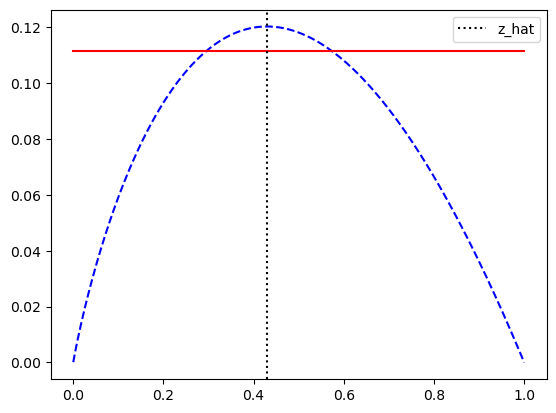

In [18]:
zgrid = np.linspace(0.0001, 1.0, 1000)
lhs = LHS(self, zgrid)
rhs = RHS(self, i)
plt.figure()
plt.plot(zgrid, lhs, '--b', zgrid, rhs*np.ones(zgrid.shape), '-r')

#plt.axvline(z_tilde)
plt.axvline(z_hat,color="black",linestyle=":",label="z_hat")
#plt.axvline(z_prime)
plt.legend()
plt.show()

In [19]:
def i_check(self, i, zstar_lhs):
    """Sufficient condition on i for Case 2b to have a non-degenerate solution
    for \breve{z}_{i}. zstar_lhs is the maximum value of the hump-shaped 
    polynomial function on the LHS of the inequality derived in Case 2b."""
    σ = self.σ_DM
    c = self.c
    zhat = z_cutoffs(self, i_test)[1]
    # lhs = 1 + i
    # rhs = (zhat**σ) * ( (1-σ)/σ)*(1 - c*((1-σ)/c)**(σ/(1-σ)) )**(-σ)
    lhs = LHS(self, zstar_lhs)
    rhs = (self.c/(1-self.σ_DM)*(1+i))**(-1/self.σ_DM)*(self.c/(1-self.σ_DM)-self.c)
    print("\n\t LHS(zstar_lhs) = %5.6f" % (lhs))
    print("\t RHS(i) = %5.6f" % (rhs))
    if lhs >= rhs:
        print("\nLHS >= RHS: Case 2b exists")
        print("\t\t\t" + r"$\breve{z}_{i} < \tilde{z}_{i}$")
    else:
        print("Not well-defined ... Case 2b")
    

In [20]:
# Case 2b does not seem to arise for too low i

# Here's an example with i_test high enough, then Case 2b exists
i_test = i*1
zstar_lhs = (1-self.σ_DM)/self.c
i_check(self, i_test, zstar_lhs)

🥳 Congrats: Your cutoffs are in order!


<IPython.core.display.Math object>

['0.398', '0.430', '1.000']

	 LHS(zstar_lhs) = 0.086348
	 RHS(i) = 0.111433
Not well-defined ... Case 2b


### Takeaway lesson from Case 2b numerical testing ...

The condition for Case 2b---i.e., when $G_{2}(\hat{\rho};z) \geq G_{1}(\rho^{m}_{0}; i)$---to exist depend on $i$ relative to a given $z$.

This condition can be re-written as

$$
  \underbrace{ z - c z^{\frac{1}{1-\sigma}} }_{LHS(z)} 
  \geq 
  \underbrace{ (1+i)^{-1/\sigma} (\sigma/c)\hat{z} }_{RHS(i)}.
$$

For fixed parameters,

* we can verify that the function on the LHS depends only on $z$, is hump-shaped, starting from 0, increasing continuously to a maximum at $z^{\ast}_{lhs} = (1-c)/\sigma$, and then descreasing to $-\infty$ as $z \nearrow \infty$;

* the RHS depends only on $i$, and thus is constant valued with respect to $z$.

* Thus for $\breve{z}_{i} \leq \tilde{z}_{i}$, we must have $LHS(z) \geq RHS(i)$. Moreover,

  * if this holds at exact equality, then Case 2b exists as a singleton set with $\breve{z}_{i} = \tilde{z}_{i}$. 
  
  * If the weak inequality is slack, then $\breve{z}_{i} < \tilde{z}_{i}$ with the smaller of the two roots solving $LHS(z) = RHS(i)$ being $\breve{z}_{i}$ and the larger root must equal $\tilde{z}_{i}$.





## Case 1a

**NOTE**:

* The function `R` has many outputs.

* The second element in the output tuple from `R` is a `SciPy` interpolant object called `Rfit`.

* You can apply the object `Rfit` directly for function evaluation when defining distribution function $J_{i}$ later.


ValueError: zero-size array to reduction operation maximum which has no identity

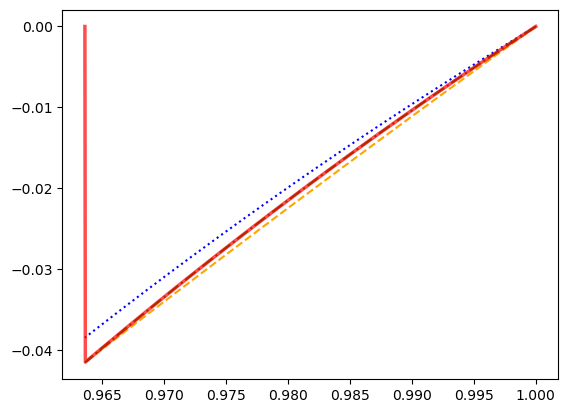

In [21]:
weight = 1.1
z = weight*z_prime
ρ_range = np.linspace(self.c, self.ρ_hat_func(z), 1000)
plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0 = plotRfun(self, i, z, ρ_range)

### Usage in SME - Notes for Sam/HS

Below is an example of `Rfit` for Case 1:

* Observe that all lotteries in this case are degenerate.

* So if you evaluate `Rfit` against `Rex` on the same grid points `ρ_range`, you should get exactly the same function evaluations.



In [13]:
τ=0.01

In [22]:
# Ex-post profit (R^{ex}) - Case 1
Rex = self.R_ex(ρ_range, i, z)

# Effective (ex-ante) but post-match lottery value/profit, R - Case 1
R_grid, R_fit, lottery_supports, lottery_payoffs = R(
    self, ρ_range, Rex, DropFakes=True)

# Note: R_fit(ρ_range) = R_grid since both are evaluated on the 
#       same domain/grid as R_grid!
if (np.absolute(R_fit(ρ_range) - Rex)).max() > 1e-12:
    print("ERROR: The two functions are not the same!")
else:
    print("All good!")

ValueError: zero-size array to reduction operation maximum which has no identity

In [50]:
R_fit.derivative()(2)

array(-0.05223619)

In [41]:
R_grid[-1]

0.05686917688214734

In [42]:
ρ_range[-1]

2.5

In [43]:
R_fit(ρ_range[-1])

array(0.05686918)

In [15]:
R_fit

As expected, the lottery set is empty:

In [16]:
lottery_supports

array([], shape=(0, 2), dtype=float64)

In [17]:
lottery_payoffs

array([], shape=(0, 2), dtype=float64)

## Case 1b

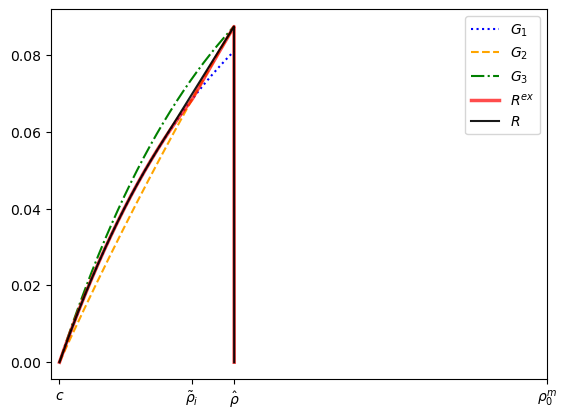

In [24]:
weight = 0.5
z = weight*z_hat + (1-weight)*z_prime
ρ_range = np.linspace(self.c, self.ρ_hat_func(z), 1000)
plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0 = plotRfun(self, i, z, ρ_range)

## Case 2a

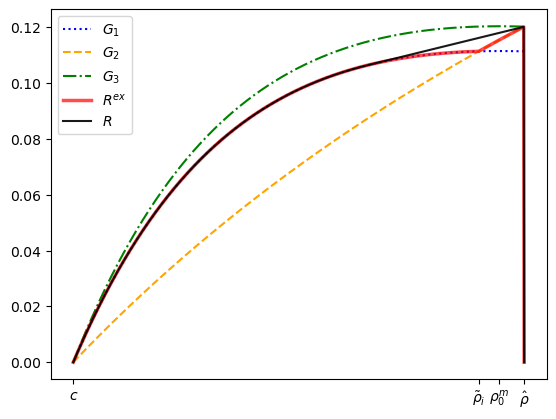

In [25]:
weight = 0.55
z = weight*z_tilde + (1-weight)*z_hat
ρ_range = np.linspace(self.c, self.ρ_hat_func(z), 1000)
plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0 = plotRfun(self, i, z, ρ_range)

In [20]:
# Ex-post profit (R^{ex}) - Case 1
Rex = self.R_ex(ρ_range, i, z)

# Effective (ex-ante) but post-match lottery value/profit, R - Case 1
R_grid, R_fit, lottery_supports, lottery_payoffs = R(
    self, ρ_range, Rex, DropFakes=True)

# Note: R_fit(ρ_range) = R_grid since both are evaluated on the 
#       same domain/grid as R_grid!
if (np.absolute(R_fit(ρ_range) - Rex)).max() > 1e-12:
    print("ERROR: The two functions are not the same!")
else:
    print("All good!")

ERROR: The two functions are not the same!


In [21]:
lottery_supports

array([[1.26846847, 1.41141141]])

In [22]:
lottery_payoffs

array([[0.10635336, 0.12016348]])

## Case 2b

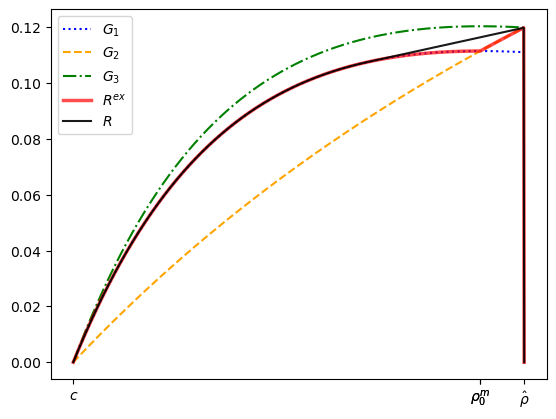

In [26]:
z = z_tilde
ρ_range = np.linspace(self.c, self.ρ_hat_func(z), 1000)
plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0 = plotRfun(self, i, z, ρ_range)

### Usage in SME - Notes for Sam/HS

Below is an example of `Rfit` for Case 2b:

* There should be a lottery.

* So if you evaluate `Rfit` against `Rex` on the same grid points `ρ_range`, you should expect gaps!



In [24]:
# Ex-post profit (R^{ex}) - Case 1
Rex = self.R_ex(ρ_range, i, z)

# Effective (ex-ante) but post-match lottery value/profit, R - Case 1
R_grid, R_fit, lottery_supports, lottery_payoffs = R(
    self, ρ_range, Rex, DropFakes=True)

# Note: R_fit(ρ_range) = R_grid since both are evaluated on the 
#       same domain/grid as R_grid!
if (np.absolute(R_fit(ρ_range) - Rex)).max() > 1e-12:
    print("WARNING: The two functions are not the same!")
else:
    print("All good!")

## Case 3

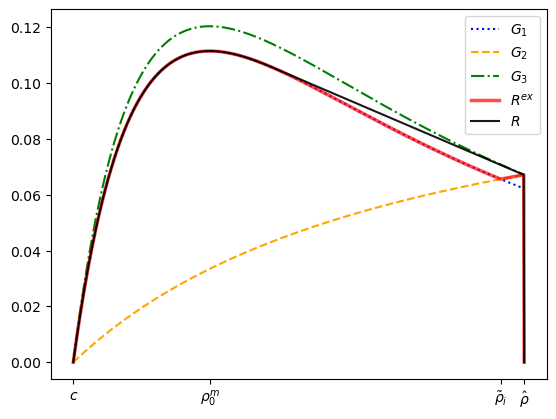

In [27]:
weight = 0.7
z = (1-weight)*z_tilde
ρ_range = np.linspace(self.c, self.ρ_hat_func(z), 1000)
plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0 = plotRfun(self, i, z, ρ_range)

## Logs

Completed:

* In this example notebook, I have modified HS/Sam's class file `bcw_bj_Lemma_1.py` by adding:

    * `InterpFun1d`

    * a vectorized version of ex-post profit function `R_ex` (previously called `R` by HS/Sam)

    * `z_cutoffs` (used directly above)

    * `R`  (used directly above)


<!-- Open issues:

* In doing this notebook, I discovered that theoretically, the currently claimed conditions on $z$ for the following cases (in **Lemma 1**):

    * Case 1/2
    
    * Case 4/5

   are actually *not sufficient* conditions, yet! This needs to be fixed to ensure the SME solution is correct. -->